In [2]:
import numpy as np
import pandas as pd
import pickle
import yaml
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix

with open('../../Data_and_models/alert_model/model_properties.pickle', 'rb') as infile:
    model_properties = pickle.load(infile)

with open('../data/dataset_cfg.yaml', 'r') as infile:
    data_cfg = yaml.safe_load(infile)

with open('cfg.yaml', 'r') as infile:
    cfg = yaml.safe_load(infile)

cat_dict = data_cfg['categorical_dict']

def cat_checker(data, features, cat_dict):
    new_data = data.copy()
    for feature in features:
        if new_data[feature].dtype.categories.to_list() != cat_dict[feature]:
            new_data[feature] = pd.Categorical(new_data[feature].values, categories=cat_dict[feature])
    
    return new_data

CATEGORICAL_COLS = data_cfg['data_cols']['categorical']


In [3]:
train = dict()
for dir in os.listdir('../../Data_and_models/testbed/'):
    train[dir] = dict()
    for dir2 in os.listdir(f'../../Data_and_models/testbed/{dir}/train_alert/'):
        train[dir][dir2] = pd.read_parquet(f'../../Data_and_models/testbed/{dir}/train_alert/{dir2}/train.parquet')
        train_properties = pd.DataFrame(columns = ['alert_rate','sub','cost','seed','fp','fn','tp','tn','correct','incorrect'])

train_properties_rescaled = pd.DataFrame(columns = ['alert_rate','sub','cost','seed','fp','fn','tp','tn','correct','incorrect'])

for setting in train:
    alert_rate = float(setting.split('-')[0].split('_')[1])
    if len(setting.split('-')) == 4:
        l = float(setting.split('-')[3].split('_')[1])
        sub = float(setting.split('-')[2].split('_')[1])
    else:
        l = float(setting.split('-')[2].split('_')[1])
        sub = 1
    for seed in train[setting]:
        train_y = train[setting][seed]['fraud_bool']
        train_preds = train[setting][seed]['decision']
        tn, fp, fn, tp = confusion_matrix(y_true = train_y, y_pred = train_preds).ravel()
        train_properties = train_properties.append(pd.Series([alert_rate,sub,l,seed,fp/(len(train_y)),fn/(len(train_y)),tp/(len(train_y)),tn/(len(train_y)),(tp+tn)/(len(train_y)),(fp+fn)/(len(train_y))], index = train_properties.columns), ignore_index=True)

train_properties.groupby(by = ['alert_rate','cost']).mean().reset_index()

,alert_rate,cost,sub,fp,fn,tp,tn,correct,incorrect
0,0.05,0.0114,1.000000,0.301655,0.003310,0.111462,0.583573,0.695035,0.304965
1,0.05,0.0570,0.583333,0.249773,0.018721,0.094225,0.637282,0.731506,0.268494
2,0.05,0.2850,1.000000,0.169310,0.056243,0.058529,0.715918,0.774447,0.225553
3,0.15,0.0114,1.000000,0.343658,0.002981,0.054653,0.598708,0.653361,0.346639
4,0.15,0.0570,0.583333,0.305627,0.014458,0.042365,0.637549,0.679915,0.320085
5,0.15,0.2850,1.000000,0.103872,0.026646,0.030988,0.838494,0.869482,0.130518


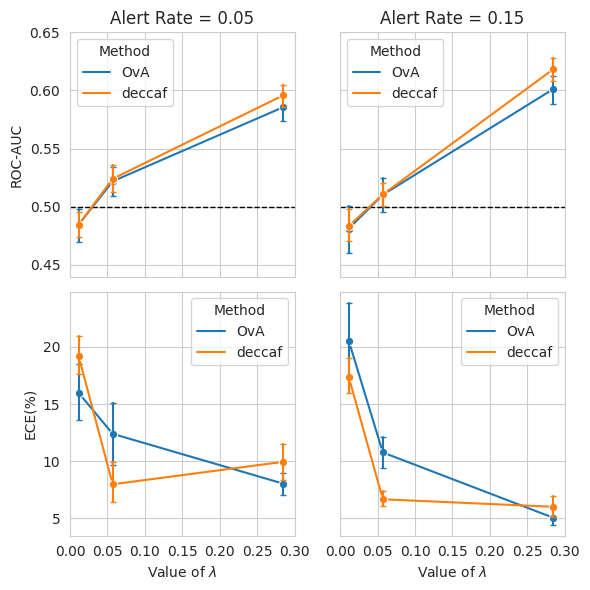

In [7]:
import pickle
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt
scens = ['alert_0.05-data_0.05','alert_0.15-data_0.05']
costs = [0.0114,0.057,0.285]

auc = pd.DataFrame()
ece = pd.DataFrame()
for scen in scens:
    for l in costs:
        alert_rate = float(scen.split('-')[0].split('_')[1])
        if len(scen.split('-')) == 2:
            sub = 1
        else:
            sub = float(scen.split('-')[2].split('_')[1])
        with open(f'../../Data_and_models/deferral/test_preds/{scen}-l_{l}/ova.pkl', 'rb') as infile:
            ova = pickle.load(infile)
        
        with open(f'../../Data_and_models/deferral/test_preds/{scen}-l_{l}/deccaf.pkl', 'rb') as infile:
            deccaf = pickle.load(infile)

        

        a = pd.read_parquet(f'../../Data_and_models/testbed/{scen}-l_{l}/test/test_expert_pred.parquet').drop(columns = 'model#0')
        b = pd.read_parquet(f'../../Data_and_models/testbed/{scen}-l_{l}/test/test.parquet')['fraud_label']

        data = pd.read_parquet(f'../../Data_and_models/data/alerts/{scen}.parquet')
        val = data.loc[data['month'] == 6]
        e_c = val['fraud_bool'].replace([0,1], [l,1]).mean()
        reb_1 = (val['fraud_bool'].mean()/e_c)
        reb_0 = (1-val['fraud_bool']).mean()*l/e_c
        test = pd.read_parquet(f'../../Data_and_models/testbed/{scen}-l_{l}/test/test.parquet')
        nmin = len(test.loc[test['fraud_label'] == 0])
        nmax = int(nmin*reb_1/reb_0)

        
        oversampled = pd.concat([test.loc[test['fraud_label'] == 0], test.loc[test['fraud_label'] == 1].sample(replace=True, n = nmax)]).index
        for seed in ova:
            for expert in a.columns:
                outcomes = (a.loc[oversampled,expert] == b.loc[oversampled]).astype(int)
                auc.loc[f'{scen}-l_{l}-{seed}-ova',expert] = roc_auc_score(y_true = outcomes, y_score = ova[seed].loc[oversampled,expert])
                prob_true, prob_pred = calibration_curve(y_true = outcomes, y_prob = ova[seed].loc[oversampled,expert], strategy='quantile', n_bins = 10)
                ece.loc[f'{scen}-l_{l}-{seed}-ova',expert] = np.mean(np.abs(prob_true - prob_pred))
                
            auc.loc[f'{scen}-l_{l}-{seed}-ova','alert_rate'] = alert_rate
            auc.loc[f'{scen}-l_{l}-{seed}-ova','seed'] = seed
            auc.loc[f'{scen}-l_{l}-{seed}-ova','model'] = 'ova'
            auc.loc[f'{scen}-l_{l}-{seed}-ova','sub'] = sub
            auc.loc[f'{scen}-l_{l}-{seed}-ova','cost'] = l

            ece.loc[f'{scen}-l_{l}-{seed}-ova','alert_rate'] = alert_rate
            ece.loc[f'{scen}-l_{l}-{seed}-ova','seed'] = seed
            ece.loc[f'{scen}-l_{l}-{seed}-ova','model'] = 'ova'
            ece.loc[f'{scen}-l_{l}-{seed}-ova','sub'] = sub
            ece.loc[f'{scen}-l_{l}-{seed}-ova','cost'] = l
        
        for seed in deccaf:
            for expert in a.columns:
                outcomes =  (a.loc[oversampled,expert] == b.loc[oversampled]).astype(int)
                auc.loc[f'{scen}-l_{l}-{seed}-deccaf',expert] = roc_auc_score(y_true = outcomes, y_score = deccaf[seed].loc[oversampled,expert])
                prob_true, prob_pred = calibration_curve(y_true = outcomes, y_prob = deccaf[seed].loc[oversampled,expert], strategy='quantile', n_bins = 10)
                ece.loc[f'{scen}-l_{l}-{seed}-deccaf',expert] = np.mean(np.abs(prob_true - prob_pred))
                
            
            auc.loc[f'{scen}-l_{l}-{seed}-deccaf','alert_rate'] = alert_rate
            auc.loc[f'{scen}-l_{l}-{seed}-deccaf','seed'] = seed
            auc.loc[f'{scen}-l_{l}-{seed}-deccaf','model'] = 'deccaf'
            auc.loc[f'{scen}-l_{l}-{seed}-deccaf','sub'] = sub
            auc.loc[f'{scen}-l_{l}-{seed}-deccaf','cost'] = l

            ece.loc[f'{scen}-l_{l}-{seed}-deccaf','alert_rate'] = alert_rate
            ece.loc[f'{scen}-l_{l}-{seed}-deccaf','seed'] = seed
            ece.loc[f'{scen}-l_{l}-{seed}-deccaf','model'] = 'deccaf'
            ece.loc[f'{scen}-l_{l}-{seed}-deccaf','sub'] = sub
            ece.loc[f'{scen}-l_{l}-{seed}-deccaf','cost'] = l

a = auc.loc[auc['alert_rate'] == 0.15].melt(id_vars=['seed','model','sub','cost','alert_rate'])
a.replace(['deccaf','ova'],['deccaf','OvA'], inplace = True)
a.rename(columns={'model': 'Method'}, inplace=True)
#a.loc[a['alert_rate'] == 0.05]
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(6, 6), ncols=2, nrows = 2, sharey = 'row', sharex='col', layout = 'tight')

sns.lineplot(ax = ax[0][1],data = a, x = 'cost', y = 'value',hue = 'Method', markers = True, marker = 'o', err_style = 'bars', err_kws={"capsize": 2})
a = auc.loc[auc['alert_rate'] == 0.05].melt(id_vars=['seed','model','sub','cost','alert_rate'])
a.replace(['deccaf','ova'],['deccaf','OvA'], inplace = True)
a.rename(columns={'model': 'Method'}, inplace=True)
#a.loc[a['alert_rate'] == 0.05]
sns.lineplot(ax = ax[0][0], data = a, x = 'cost', y = 'value',hue = 'Method', markers = True, marker = 'o', err_style = 'bars', err_kws={"capsize": 2})


ax[0][0].set_title("Alert Rate = 0.05")
ax[0][1].set_title("Alert Rate = 0.15")

for x in ax[0]:
    x.set_ylabel('ROC-AUC')
    x.set_xlabel(r'Value of $\lambda$')
    x.set_xticks(np.arange(0,0.30001,0.05))
    x.set_xlim([0,0.3])
    x.set_ylim([0.44,0.645])
    x.set_yticks(np.arange(0.45,0.66,0.05))

ax[0][0].axhline(y=0.50,xmin=0,xmax=3,c="black",linewidth=1,zorder=1, linestyle = '--')
ax[0][1].axhline(y=0.50,xmin=0,xmax=3,c="black",linewidth=1,zorder=1, linestyle = '--')


a = ece.loc[ece['alert_rate'] == 0.15].melt(id_vars=['seed','model','sub','cost','alert_rate'])
a['value'] = a['value']*100
a.replace(['deccaf','ova'],['deccaf','OvA'], inplace = True)
a.rename(columns={'model': 'Method'}, inplace=True)
#a.loc[a['alert_rate'] == 0.05]
sns.set_style("whitegrid")

sns.lineplot(ax = ax[1][1],data = a, x = 'cost', y = 'value',hue = 'Method', markers = True, marker = 'o', err_style = 'bars', err_kws={"capsize": 2})
a = ece.loc[ece['alert_rate'] == 0.05].melt(id_vars=['seed','model','sub','cost','alert_rate'])
a['value'] = a['value']*100
a.replace(['deccaf','ova'],['deccaf','OvA'], inplace = True)
a.rename(columns={'model': 'Method'}, inplace=True)
#a.loc[a['alert_rate'] == 0.05]
sns.lineplot(ax = ax[1][0], data = a, x = 'cost', y = 'value',hue = 'Method', markers = True, marker = 'o', err_style = 'bars', err_kws={"capsize": 2})

for x in ax[1]:
    x.set_xlabel(r'Value of $\lambda$')
    x.set_xticks(np.arange(0,0.30001,0.05))
    x.set_xlim([0,0.3])
    x.set_ylabel('ECE(%)')
    

#plt.yticks(np.arange(0.45,0.66,0.05))

plt.savefig("ROC-AUC_individual.pdf", format="pdf", bbox_inches="tight")

plt.show()


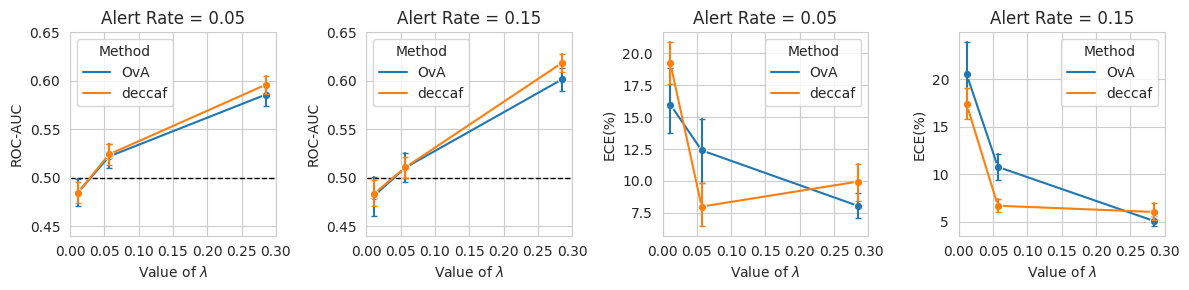

In [8]:
a = auc.loc[auc['alert_rate'] == 0.15].melt(id_vars=['seed','model','sub','cost','alert_rate'])
a.replace(['deccaf','ova'],['deccaf','OvA'], inplace = True)
a.rename(columns={'model': 'Method'}, inplace=True)
#a.loc[a['alert_rate'] == 0.05]
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(12, 3), ncols=4, nrows = 1, layout = 'tight')

sns.lineplot(ax = ax[1],data = a, x = 'cost', y = 'value',hue = 'Method', markers = True, marker = 'o', err_style = 'bars', err_kws={"capsize": 2})
a = auc.loc[auc['alert_rate'] == 0.05].melt(id_vars=['seed','model','sub','cost','alert_rate'])
a.replace(['deccaf','ova'],['deccaf','OvA'], inplace = True)
a.rename(columns={'model': 'Method'}, inplace=True)
#a.loc[a['alert_rate'] == 0.05]
sns.lineplot(ax = ax[0], data = a, x = 'cost', y = 'value',hue = 'Method', markers = True, marker = 'o', err_style = 'bars', err_kws={"capsize": 2})


ax[0].set_title("Alert Rate = 0.05")
ax[1].set_title("Alert Rate = 0.15")

for x in [ax[0],ax[1]]:
    x.set_ylabel('ROC-AUC')
    x.set_xlabel(r'Value of $\lambda$')
    x.set_xticks(np.arange(0,0.30001,0.05))
    x.set_xlim([0,0.3])
    x.set_ylim([0.44,0.645])
    x.set_yticks(np.arange(0.45,0.66,0.05))

ax[0].axhline(y=0.50,xmin=0,xmax=3,c="black",linewidth=1,zorder=1, linestyle = '--')
ax[1].axhline(y=0.50,xmin=0,xmax=3,c="black",linewidth=1,zorder=1, linestyle = '--')


a = ece.loc[ece['alert_rate'] == 0.15].melt(id_vars=['seed','model','sub','cost','alert_rate'])
a['value'] = a['value']*100
a.replace(['deccaf','ova'],['deccaf','OvA'], inplace = True)
a.rename(columns={'model': 'Method'}, inplace=True)
#a.loc[a['alert_rate'] == 0.05]
sns.set_style("whitegrid")

sns.lineplot(ax = ax[3],data = a, x = 'cost', y = 'value',hue = 'Method', markers = True, marker = 'o', err_style = 'bars', err_kws={"capsize": 2})
a = ece.loc[ece['alert_rate'] == 0.05].melt(id_vars=['seed','model','sub','cost','alert_rate'])
a['value'] = a['value']*100
a.replace(['deccaf','ova'],['deccaf','OvA'], inplace = True)
a.rename(columns={'model': 'Method'}, inplace=True)
#a.loc[a['alert_rate'] == 0.05]
sns.lineplot(ax = ax[2], data = a, x = 'cost', y = 'value',hue = 'Method', markers = True, marker = 'o', err_style = 'bars', err_kws={"capsize": 2})


ax[2].set_title("Alert Rate = 0.05")
ax[3].set_title("Alert Rate = 0.15")


for x in [ax[2],ax[3]]:
    x.set_xlabel(r'Value of $\lambda$')
    x.set_xticks(np.arange(0,0.30001,0.05))
    x.set_xlim([0,0.3])
    x.set_ylabel('ECE(%)')
    

#plt.yticks(np.arange(0.45,0.66,0.05))

plt.savefig("ROC-AUC_individual_horiz.pdf", format="pdf", bbox_inches="tight")

plt.show()


# Loading Results

In [11]:
from sklearn.metrics import confusion_matrix

test_env_df = pd.DataFrame(columns = ['scen','cost','sub', 'alert_rate','training_seed',
                                        'model',
                                        'batch_size',
                                        'batch_seed', 
                                        'absence_rate', 
                                        'absence_seed', 
                                        'distribution', 
                                        'distribution_std', 
                                        'distribution_seed', 
                                        'deferral_rate',
                                        'pool',
                                        'n_errors',
                                        'tp',
                                        'fp',
                                        'fn',
                                        'tn',
                                        'tpr',
                                        'fpr',
                                        'fpr_disp'])



costs = cfg['costs']

if not os.path.isfile('../../Data_and_models/deferral/def_results_alert/results.parquet'):
    for scen in os.listdir('../../Data_and_models/data/alerts'):
        if len(scen.split('-')) == 3:
            sub_test_bool = True
        else:
            sub_test_bool = False
        for l in costs:
            if sub_test_bool and (l not in cfg['run_sub']):
                continue
            scen = scen.split('.parquet')[0]
            print(f'{scen}-l_{l}')
            alerts = pd.read_parquet(f'../../Data_and_models/data/alerts/{scen}.parquet')
            test = alerts.loc[alerts['month'] == 7]
            a = dict()
            for direc in os.listdir(f'../../Data_and_models/testbed/{scen}-l_{l}/test/'):
                if os.path.isfile(f'../../Data_and_models/testbed/{scen}-l_{l}/test/' + direc):
                    continue
                a[direc] = dict()
                a[direc]['bat'] = pd.read_csv(f'../../Data_and_models/testbed/{scen}-l_{l}/test/' + direc + '/batches.csv')
                a[direc]['cap'] = pd.read_csv(f'../../Data_and_models/testbed/{scen}-l_{l}/test/' + direc + '/capacity.csv')


            alert_rate = float(scen.split('-')[0].split('_')[1])

            seeds = os.listdir(f'../../Data_and_models/deferral/def_results_alert/{scen}-l_{l}/')
            for seed in seeds:
                if seed in ['Random','Full_Rej','Only_Classifier']:
                    continue
                models = ['DeCCaF','OvA']
                if len(scen.split('-')) ==2:
                    sub = 1
                else:
                    sub = float(scen.split('-')[2].split('_')[1])
                    if l != 0.057:
                        continue
                    
                for model in models:
                        for test_env_id in a:
                            #print(f'evaluating model {model} in {test_env_id}')
                            direc = test_env_id
                            test_env_id = test_env_id.split('#')
                            
                            batch_size = 4457
                            batch_seed = 1

                            if test_env_id[1].split('_')[0] == 'homogenous':
                                distribution = 'homogenous'
                                distribution_seed = 'NA'
                                distribution_std = 'NA'
                            else:
                                distribution = 'variable'
                                distribution_seed = test_env_id[1].split('_')[0].split('-')[1]
                                distribution_std = '0.2'

                            absence = 0
                            absence_seed = 'NA'
                            exp_pool = 'standard'
                            deferral_rate = 0.9
                                
                        
                            reviews = pd.read_parquet(f'../../Data_and_models/deferral/def_results_alert/{scen}-l_{l}/{seed}/{model}/{direc}/results.parquet')
                            reviews = reviews['prediction']
                            labels = test.loc[reviews.index,'fraud_bool']

                            n_errors = (reviews != labels).astype(int).mean()
                            tn, fp, fn, tp = confusion_matrix(y_true = labels, y_pred = reviews).ravel()
                            tpr = tp/(tp+fn)
                            fpr = fp/(fp+tn)
                            
                            sub_test = test.loc[reviews.index,:]
                            old_ix = sub_test.loc[test['customer_age'] >= 50].index
                            yng_ix = sub_test.loc[test['customer_age'] < 50].index


                            old_pred = reviews.loc[old_ix]
                            old_label = labels.loc[old_ix]
                            fp_old = ((old_pred == 1) & (old_label == 0)).astype(int).sum()
                            tn_old = ((old_pred == 0) & (old_label == 0)).astype(int).sum()

                            yng_pred = reviews.loc[yng_ix]
                            yng_label = labels.loc[yng_ix]
                            fp_yng = ((yng_pred == 1) & (yng_label == 0)).astype(int).sum()
                            tn_yng = ((yng_pred == 0) & (yng_label == 0)).astype(int).sum()

                            fpr_yng = fp_yng/(fp_yng + tn_yng)
                            fpr_old = fp_old/(fp_old + tn_old)

                            fpr_disp =  fpr_yng/fpr_old
                            test_env_df = test_env_df.append(pd.Series([scen,l,sub, alert_rate, seed,model,batch_size, 
                                                                        batch_seed, 
                                                                        absence,
                                                                        absence_seed, 
                                                                        distribution, 
                                                                        distribution_std, 
                                                                        distribution_seed, 
                                                                        deferral_rate,
                                                                        exp_pool,
                                                                        n_errors,
                                                                        tp,
                                                                        fp,
                                                                        fn,
                                                                        tn,
                                                                        tpr,
                                                                        fpr, 
                                                                        fpr_disp], index = test_env_df.columns), ignore_index = True)

            models = ['Random','Full_Rej','Only_Classifier']

            for model in models:
                        if len(scen.split('-')) ==2:
                            sub = 1
                        else:
                            sub = float(scen.split('-')[2].split('_')[1])
                            if l != 0.057:
                                continue
                        for test_env_id in a:
                            direc = test_env_id
                            test_env_id = test_env_id.split('#')
                            batch_size = 4457
                            batch_seed = 1

                            if test_env_id[1].split('_')[0] == 'homogenous':
                                distribution = 'homogenous'
                                distribution_seed = 'NA'
                                distribution_std = 'NA'
                            else:
                                distribution = 'variable'
                                distribution_seed = test_env_id[1].split('_')[0].split('-')[1]
                                distribution_std = '0.2'

                            absence = 0
                            absence_seed = 'NA'
                            deferral_rate = 0.9
                            exp_pool = 'standard'
                            
                            reviews = pd.read_parquet(f'../../Data_and_models/deferral/def_results_alert/{scen}-l_{l}/{model}/{direc}/results.parquet')
                            reviews = reviews['prediction']
                            labels = test.loc[reviews.index,'fraud_bool']

                            n_errors = (reviews != labels).astype(int).mean()
                            tn, fp, fn, tp = confusion_matrix(y_true = labels, y_pred = reviews).ravel()
                            tpr = tp/(tp+fn)
                            fpr = fp/(fp+tn)
                            
                            sub_test = test.loc[reviews.index,:]
                            old_ix = sub_test.loc[test['customer_age'] >= 50].index
                            yng_ix = sub_test.loc[test['customer_age'] < 50].index


                            old_pred = reviews.loc[old_ix]
                            old_label = labels.loc[old_ix]
                            fp_old = ((old_pred == 1) & (old_label == 0)).astype(int).sum()
                            tn_old = ((old_pred == 0) & (old_label == 0)).astype(int).sum()

                            yng_pred = reviews.loc[yng_ix]
                            yng_label = labels.loc[yng_ix]
                            fp_yng = ((yng_pred == 1) & (yng_label == 0)).astype(int).sum()
                            tn_yng = ((yng_pred == 0) & (yng_label == 0)).astype(int).sum()

                            fpr_yng = fp_yng/(fp_yng + tn_yng)
                            fpr_old = fp_old/(fp_old + tn_old)

                            fpr_disp =  fpr_yng/fpr_old
                            test_env_df = test_env_df.append(pd.Series([scen,l,sub,alert_rate, 'NA',model,batch_size, 
                                                                        batch_seed, 
                                                                        absence,
                                                                        absence_seed, 
                                                                        distribution, 
                                                                        distribution_std, 
                                                                        distribution_seed, 
                                                                        deferral_rate,
                                                                        exp_pool,
                                                                        n_errors,
                                                                        tp,
                                                                        fp,
                                                                        fn,
                                                                        tn,
                                                                        tpr,
                                                                        fpr, 
                                                                        fpr_disp], index = test_env_df.columns), ignore_index = True)
                            

    test_env_df['cost/100 instances'] = test_env_df['fp']*test_env_df['cost'] + test_env_df['fn']
    test_env_df['cost/100 instances'] = test_env_df['cost/100 instances'].astype('float')/(test_env_df['fp'] + test_env_df['fn'] +test_env_df['tp'] + test_env_df['tn']).astype('float')*100
    test_env_df = test_env_df.replace('NA',np.nan)
    test_env_df.to_parquet('../../Data_and_models/deferral/def_results_alert/results.parquet')
else:
    test_env_df = pd.read_parquet('../../Data_and_models/deferral/def_results_alert/results.parquet')

alert_0.05-data_0.05-l_0.0114
alert_0.05-data_0.05-l_0.057
alert_0.05-data_0.05-l_0.285
alert_0.05-data_0.05-sub_0.25-l_0.057
alert_0.15-data_0.05-sub_0.50-l_0.057
alert_0.15-data_0.05-sub_0.25-l_0.057
alert_0.05-data_0.05-sub_0.50-l_0.057
alert_0.15-data_0.05-l_0.0114
alert_0.15-data_0.05-l_0.057
alert_0.15-data_0.05-l_0.285


In [12]:
test_env_df = test_env_df.loc[(test_env_df['sub'] == 1.0)|test_env_df['sub'].isna()]
test_env_df['cost/100 instances'] = (test_env_df['fp']*test_env_df['cost'] + test_env_df['fn'])/(test_env_df['fp'] + test_env_df['tn'] + test_env_df['fn'] + test_env_df['tp'])*100
a = test_env_df.groupby(['scen','cost','model','distribution', 'distribution_seed','training_seed'], dropna = False).mean().loc[:,['tpr','fpr','cost/100 instances']].round(2)
a = a.reset_index()
a_5 = a.loc[a['scen'] == 'alert_0.05-data_0.05']
a_15 = a.loc[a['scen'] == 'alert_0.15-data_0.05']

ova = test_env_df.loc[test_env_df['model'] == 'OvA']
deccaf = test_env_df.loc[test_env_df['model'] == 'DeCCaF']
ran = test_env_df.loc[test_env_df['model'] == 'Random']
rej = test_env_df.loc[test_env_df['model'] == 'Full_Rej']
aux = test_env_df.loc[test_env_df['model'] == 'Only_Classifier']
sns.set_style('whitegrid')

In [14]:
((deccaf.groupby(by = ['alert_rate','cost']).mean().reset_index().loc[:,'cost/100 instances'] - ova.groupby(by = ['alert_rate','cost']).mean().reset_index().loc[:,'cost/100 instances'])/ova.groupby(by = ['alert_rate','cost']).mean().reset_index().loc[:,'cost/100 instances']*100).mean()

-8.695124778789568

In [16]:
table = pd.DataFrame()
table = rej.groupby(by = ['alert_rate','cost']).mean().loc[:,'cost/100 instances'].reset_index().copy()

table = table.rename(columns = {'cost/100 instances': 'Full_Rej'})
table['Full_Rej'] = "$" + table['Full_Rej'].round(2).astype(str) + "$" 
table['Only_Classifier'] = "$ " + aux.groupby(by = ['alert_rate','cost']).mean().reset_index().loc[:,'cost/100 instances'].round(2).astype(str) + '$'
table['Random'] = "$ "  + ran.groupby(by = ['alert_rate','cost']).mean().reset_index().loc[:,'cost/100 instances'].round(2).astype(str)  + ' \mbox{\scriptsize{$\pm '+  (ran.groupby(by = ['alert_rate','cost']).std().reset_index().loc[:,'cost/100 instances']*1.96/np.sqrt(ran.groupby(by = ['alert_rate','cost']).count().reset_index().loc[:,'cost/100 instances'])).round(2).astype(str)+ "$ }} $"
table['OvA'] ="$ "  + ova.groupby(by = ['alert_rate','cost']).mean().reset_index().loc[:,'cost/100 instances'].round(2).astype(str) + ' \mbox{\scriptsize{$\pm '+  (ova.groupby(by = ['alert_rate','cost']).std().reset_index().loc[:,'cost/100 instances']*1.96/np.sqrt(ova.groupby(by = ['alert_rate','cost']).count().reset_index().loc[:,'cost/100 instances'])).round(2).astype(str)+ "$ }} $"
table['DeCCaF'] = "$ "  +deccaf.groupby(by = ['alert_rate','cost']).mean().reset_index().loc[:,'cost/100 instances'].round(2).astype(str) + ' \mbox{\scriptsize{$\pm '+  (deccaf.groupby(by = ['alert_rate','cost']).std().reset_index().loc[:,'cost/100 instances']*1.96/np.sqrt(deccaf.groupby(by = ['alert_rate','cost']).count().reset_index().loc[:,'cost/100 instances'])).round(2).astype(str)+ "$ }} $"
table


,alert_rate,cost,Full_Rej,Only_Classifier,Random,OvA,DeCCaF
0,0.05,0.0114,$0.96$,$ 0.96$,$ 0.8 \mbox{\scriptsize{$\pm 0.08$ }} $,$ 0.84 \mbox{\scriptsize{$\pm 0.06$ }} $,$ 0.79 \mbox{\scriptsize{$\pm 0.04$ }} $
1,0.05,0.0570,$4.79$,$ 4.58$,$ 3.95 \mbox{\scriptsize{$\pm 0.17$ }} $,$ 3.63 \mbox{\scriptsize{$\pm 0.07$ }} $,$ 3.4 \mbox{\scriptsize{$\pm 0.04$ }} $
2,0.05,0.2850,$23.95$,$ 14.08$,$ 12.23 \mbox{\scriptsize{$\pm 0.19$ }} $,$ 11.13 \mbox{\scriptsize{$\pm 0.04$ }} $,$ 10.21 \mbox{\scriptsize{$\pm 0.17$ }} $
3,0.15,0.0114,$1.05$,$ 1.07$,$ 0.87 \mbox{\scriptsize{$\pm 0.05$ }} $,$ 0.87 \mbox{\scriptsize{$\pm 0.02$ }} $,$ 0.74 \mbox{\scriptsize{$\pm 0.03$ }} $
4,0.15,0.0570,$5.27$,$ 4.01$,$ 3.45 \mbox{\scriptsize{$\pm 0.13$ }} $,$ 3.55 \mbox{\scriptsize{$\pm 0.03$ }} $,$ 3.19 \mbox{\scriptsize{$\pm 0.03$ }} $
5,0.15,0.2850,$26.36$,$ 6.93$,$ 6.0 \mbox{\scriptsize{$\pm 0.14$ }} $,$ 5.23 \mbox{\scriptsize{$\pm 0.08$ }} $,$ 4.85 \mbox{\scriptsize{$\pm 0.09$ }} $


In [18]:
comp = pd.DataFrame(columns = ['alert_rate','cost','model','deccaf_is_better'])
alert_rates = [0.05,0.15]

for alert_rate in alert_rates:
        for cost in cfg['costs']:
            avg = 0
            for seed in ['5k-1#regular','5k-2#regular','5k-3#regular','5k-4#regular','5k-5#regular']:
                a = deccaf.loc[(deccaf['training_seed'] == seed) & (deccaf['cost'] == cost) & (deccaf['alert_rate'] == alert_rate)]
                model_2 = ova.loc[(ova['training_seed'] == seed)& (ova['cost'] == cost) & (ova['alert_rate'] == alert_rate)]
                avg += (a['cost/100 instances'].reset_index(drop = True) < model_2['cost/100 instances'].reset_index(drop = True)).astype(int).mean()
            
            avg = avg/5

            comp = comp.append(pd.Series([alert_rate, cost, 'ova', avg], index = comp.columns), ignore_index = True)

for model_n in ['Random','Full_Rej','Only_Classifier']:
    model = test_env_df.loc[test_env_df['model'] == model_n]
    
    for alert_rate in alert_rates:
        for cost in cfg['costs']:
            avg = 0
            for seed in ['5k-1#regular','5k-2#regular','5k-3#regular','5k-4#regular','5k-5#regular']:
                a = deccaf.loc[(deccaf['training_seed'] == seed) & (deccaf['cost'] == cost) & (deccaf['alert_rate'] == alert_rate)]
                model_2 = model.loc[(model['cost'] == cost) & (model['alert_rate'] == alert_rate)]
                avg += (a['cost/100 instances'].reset_index(drop = True) < model_2['cost/100 instances'].reset_index(drop = True)).astype(int).mean()
            
            avg = avg/5

            comp = comp.append(pd.Series([alert_rate, cost, model_n, avg], index = comp.columns), ignore_index = True)

temp = comp.iloc[:6,:2]
temp['ova'] = comp.loc[comp['model'] == 'ova']['deccaf_is_better']
temp['Random'] = comp.loc[comp['model'] == 'Random']['deccaf_is_better'].reset_index(drop = True)
temp['Full_Rej'] = comp.loc[comp['model'] == 'Full_Rej']['deccaf_is_better'].reset_index(drop = True)
temp['Only_Classifier'] = comp.loc[comp['model'] == 'Only_Classifier']['deccaf_is_better'].reset_index(drop = True)
temp

,alert_rate,cost,ova,Random,Full_Rej,Only_Classifier
0,0.05,0.0114,0.52,0.56,0.88,0.88
1,0.05,0.0570,0.76,1.00,1.00,1.00
2,0.05,0.2850,0.96,1.00,1.00,1.00
3,0.15,0.0114,0.84,0.88,1.00,1.00
4,0.15,0.0570,1.00,0.96,1.00,1.00
5,0.15,0.2850,0.96,1.00,1.00,1.00


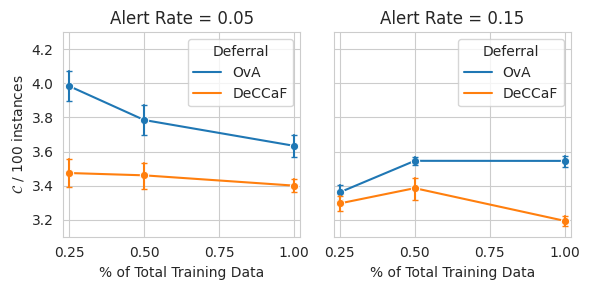

In [20]:
test_env_df = pd.read_parquet('../../Data_and_models/deferral/def_results_alert/results.parquet')
test_env_df = test_env_df.loc[test_env_df['cost'] == 0.057]
test_env_df['cost/100 instances'] = (test_env_df['fp']*test_env_df['cost'] + test_env_df['fn'])/(test_env_df['fp'] + test_env_df['tn'] + test_env_df['fn'] + test_env_df['tp'])*100
a = test_env_df.loc[(test_env_df['deferral_rate'] == 0.9)].groupby(['scen','alert_rate','cost','model','distribution', 'distribution_seed','training_seed','sub'], dropna = False).mean().loc[:,['tpr','fpr','cost/100 instances']].round(2)
a = a.reset_index()
a = a.drop(a.loc[a['sub'].isna()].index)
a = a.drop(a.loc[a['model'] == 'OvA-default'].index)
a_5 = a.loc[a['alert_rate'] == 0.05]
a_5 = a_5.drop(a_5.loc[(a_5['model'] == 'Full_Rej')].index)
a_5 = a_5.drop(a_5.loc[(a_5['model'] == 'Random')].index)
a_5 = a_5.drop(a_5.loc[(a_5['model'] == 'Only_Classifier')].index)
a_5['Deferral'] = a_5['model']
a_15 = a.loc[a['alert_rate'] == 0.15]
a_15 = a_15.drop(a_15.loc[(a_15['model'] == 'Full_Rej')].index)
a_15 = a_15.drop(a_15.loc[(a_15['model'] == 'Random')].index)
a_15 = a_15.drop(a_15.loc[(a_15['model'] == 'Only_Classifier')].index)
a_15['Deferral'] = a_15['model']

f, ax = plt.subplots(figsize=(6, 3), ncols=2, sharey = True, layout = 'tight')
sns.lineplot(ax = ax[0], data = a_5, x = 'sub', y = 'cost/100 instances', hue = 'Deferral', markers = True, hue_order=['OvA','DeCCaF'], marker = 'o', errorbar = ("ci",95),err_style = 'bars', err_kws={"capsize": 2})
sns.lineplot(ax = ax[1], data = a_15, x = 'sub', y = 'cost/100 instances', hue = 'Deferral', markers = True, hue_order=['OvA','DeCCaF'], marker = 'o', err_style = 'bars', err_kws={"capsize": 2})
ax[0].set_title("Alert Rate = 0.05")
ax[1].set_title("Alert Rate = 0.15")
plt.ylim([3.1,4.3])
for x in ax:
    x.set_xlabel(r'% of Total Training Data')
    x.set_xticks(np.arange(0.25,1.02,0.25))
    x.set_ylabel(r'$\mathcal{C}$ / 100 instances')
    x.set_xlim([0.23,1.02])
    
plt.savefig("Cost-sub.pdf", format="pdf", bbox_inches="tight")

In [21]:
import pickle
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt
scens = ['alert_0.05-data_0.05','alert_0.15-data_0.05']
costs = [0.0114,0.057,0.285]

auc_ece_model = pd.DataFrame()

for scen in scens:
    for l in costs:
        alert_rate = float(scen.split('-')[0].split('_')[1])
        if len(scen.split('-')) == 2:
            sub = 1
        else:
            sub = float(scen.split('-')[2].split('_')[1])

        a = pd.read_parquet(f'../../Data_and_models/testbed/{scen}-l_{l}/test/test_expert_pred.parquet')['model#0']
        b = pd.read_parquet(f'../../Data_and_models/testbed/{scen}-l_{l}/test/test.parquet')['fraud_label']

        data = pd.read_parquet(f'../../Data_and_models/data/alerts/{scen}.parquet')
        val = data.loc[data['month'] == 6]
        e_c = val['fraud_bool'].replace([0,1], [l,1]).mean()
        reb_1 = (val['fraud_bool'].mean()/e_c)
        reb_0 = (1-val['fraud_bool']).mean()*l/e_c
        test = pd.read_parquet(f'../../Data_and_models/testbed/{scen}-l_{l}/test/test.parquet')
        nmin = len(test.loc[test['fraud_label'] == 0])
        nmax = int(nmin*reb_1/reb_0)
        oversampled = pd.concat([test.loc[test['fraud_label'] == 0], test.loc[test['fraud_label'] == 1].sample(replace=True, n = nmax, random_state=42)]).index
        outcomes = b.loc[oversampled]
        prob_true, prob_pred = calibration_curve(y_true = outcomes, y_prob = a.loc[oversampled], strategy='quantile', n_bins = 10)

        auc_ece_model.loc[f'{scen}-l_{l}','alert_rate'] = alert_rate
        auc_ece_model.loc[f'{scen}-l_{l}','cost'] = l
        auc_ece_model.loc[f'{scen}-l_{l}','roc'] = roc_auc_score(y_true = outcomes, y_score = a.loc[oversampled])
        auc_ece_model.loc[f'{scen}-l_{l}','ece'] = np.mean(np.abs(prob_true - prob_pred))*100




In [22]:
auc_ece_model.round(3)

,alert_rate,cost,roc,ece
alert_0.05-data_0.05-l_0.0114,0.05,0.011,0.698,1.110
alert_0.05-data_0.05-l_0.057,0.05,0.057,0.707,4.844
alert_0.05-data_0.05-l_0.285,0.05,0.285,0.706,4.550
alert_0.15-data_0.05-l_0.0114,0.15,0.011,0.757,3.777
alert_0.15-data_0.05-l_0.057,0.15,0.057,0.754,4.196
alert_0.15-data_0.05-l_0.285,0.15,0.285,0.732,3.281


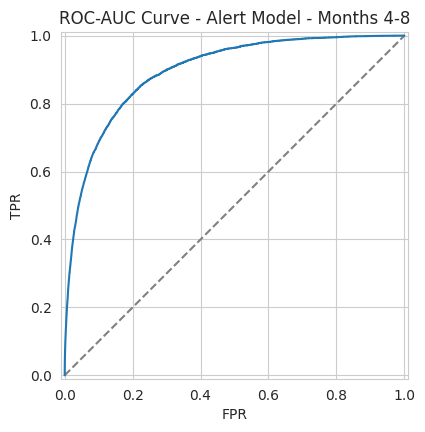

In [23]:
a = pd.read_parquet('../../Data_and_models/data/BAF_deployment_score.parquet')
from sklearn.metrics import roc_curve
f, ax = plt.subplots(figsize = (4.5,4.5))
fpr, tpr, thresholds = roc_curve(a['fraud_bool'], a['model_score'])
plt.gca().set_aspect('equal')
plt.plot([0,1],[0,1], color = 'gray', linestyle = '--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.title("ROC-AUC Curve - Alert Model - Months 4-8")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.plot(fpr,tpr)
plt.savefig("ROC-AUC_Alert_model.pdf", format="pdf", bbox_inches="tight")